# Model Building

## Load necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
RANDOM_STATE=0
pd.set_option('display.max_columns', 100)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

In [3]:
# Load the data into a Pandas dataframe

mdClean = pd.read_csv('mdClean.csv', sep=',', index_col=0)
mdClean.head()

,Year_Birth,Education,Income,Recency,NumWebVisitsMonth,Complain,Response,RelStatus,amountSpent,numOfPurchases,numOfMinorsHome,prvAcceptedCampaigns,dateCust,dateCustYear,custAge
0,1957,Graduation,58138.0,58,7,0,1,Single,1617,25,0,0,2012-09-04,2012,55
1,1954,Graduation,46344.0,38,5,0,0,Single,27,6,2,0,2014-03-08,2014,60
2,1965,Graduation,71613.0,26,4,0,0,Coupled,776,21,0,0,2013-08-21,2013,48
3,1984,Graduation,26646.0,26,6,0,0,Coupled,53,8,1,0,2014-02-10,2014,30
4,1981,PhD,58293.0,94,5,0,0,Coupled,422,19,1,0,2014-01-19,2014,33


In [4]:
mdClean.shape

(2235, 15)

## Data Preparation

In [5]:
y = mdClean.Response
X = mdClean.drop(['Response'], axis=1)
cols = X.columns

In [6]:
print(y)
print(y.sum())
print(y.describe())

0       1
1       0
2       0
3       0
4       0
       ..
2235    0
2236    0
2237    0
2238    0
2239    1
Name: Response, Length: 2235, dtype: int64
332
count    2235.000000
mean        0.148546
std         0.355720
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Response, dtype: float64


### Split into training, validation, and testing data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=RANDOM_STATE)

In [8]:
# Convert y into int type
y_train = y_train.astype('int')

y_val = y_val.astype('int')

y_test = y_test.astype('int')

### Standardize training, validation, and testing X data

Our descriptive statistics indicated our variables have varying ranges, so we standardized our data using scikit learn's Standard Scalar.

In [9]:
# Create numeric datasets by dropping categorical variables

X_train_ss = X_train.drop(columns=['Education', 'RelStatus', 'dateCust'])
cols = X_train_ss.columns

X_val_ss = X_val.drop(columns=['Education','dateCust', 'RelStatus'])

X_test_ss = X_test.drop(columns=['Education','dateCust', 'RelStatus'])

In [10]:
# Use standard scalar to standardize X data
ss = StandardScaler()
ss.fit(X_train_ss)

X_train_ss = ss.transform(X_train_ss)
X_val_ss = ss.transform(X_val_ss)
X_test_ss = ss.transform(X_test_ss)

In [11]:
# Convert back to pd.DataFrame

X_train_ss = pd.DataFrame(X_train_ss, columns=cols)
X_train_ss

,Year_Birth,Income,Recency,NumWebVisitsMonth,Complain,amountSpent,numOfPurchases,numOfMinorsHome,prvAcceptedCampaigns,dateCustYear,custAge
0,0.197814,-0.465168,-1.066122,1.138337,-0.10296,-0.953389,-1.303463,0.053770,-0.444879,-0.025056,-0.198519
1,-1.123643,-0.636986,0.112398,-0.532938,-0.10296,-0.948441,-1.042057,1.379484,-0.444879,1.467865,1.200724
2,1.436681,1.269167,-1.655381,-1.368575,-0.10296,1.679341,0.918484,-1.271944,-0.444879,1.467865,-1.350836
3,-1.288825,0.176040,0.563009,-0.532938,-0.10296,0.066051,0.918484,0.053770,-0.444879,-0.025056,1.283032
4,-1.288825,1.522548,0.840307,-1.368575,-0.10296,0.666499,0.395673,-1.271944,3.912493,-0.025056,1.283032
...,...,...,...,...,...,...,...,...,...,...,...
1425,-0.710688,1.438368,1.533554,-0.950757,-0.10296,0.209565,0.526376,-1.271944,-0.444879,-1.517977,0.624565
1426,0.775952,-1.110581,-0.234225,0.302699,-0.10296,-0.894005,-0.780652,0.053770,-0.444879,1.467865,-0.692369
1427,0.197814,-0.144424,1.498892,0.720518,-0.10296,0.445455,1.310592,0.053770,-0.444879,-1.517977,-0.280827
1428,0.610770,-0.998231,1.186931,0.720518,-0.10296,-0.951740,-1.303463,0.053770,-0.444879,-0.025056,-0.610061


In [12]:
# Convert validation and testing back to pd.DataFrame
X_val_ss = pd.DataFrame(X_val_ss, columns=cols)
X_test_ss = pd.DataFrame(X_test_ss, columns=cols)

In [13]:
# Add back in the categorical variables Education and RelStatus

X_train_ss['Education'] = X_train['Education']
X_train_ss['RelStatus'] = X_train['RelStatus']

X_val_ss['Education'] = X_val['Education']
X_val_ss['RelStatus'] = X_val['RelStatus']

X_test_ss['Education'] = X_test['Education']
X_test_ss['RelStatus'] = X_test['RelStatus']


In [14]:
# Get dummy variables for education and RelStatus
Xtrain = pd.get_dummies(X_train_ss)

Xval = pd.get_dummies(X_val_ss)

Xtest = pd.get_dummies(X_test_ss)

In [15]:
Xtrain.head() # display the top 5 records

,Year_Birth,Income,Recency,NumWebVisitsMonth,Complain,amountSpent,numOfPurchases,numOfMinorsHome,prvAcceptedCampaigns,dateCustYear,custAge,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,RelStatus_Coupled,RelStatus_Single
0,0.197814,-0.465168,-1.066122,1.138337,-0.10296,-0.953389,-1.303463,0.053770,-0.444879,-0.025056,-0.198519,0,0,1,0,0,0,1
1,-1.123643,-0.636986,0.112398,-0.532938,-0.10296,-0.948441,-1.042057,1.379484,-0.444879,1.467865,1.200724,0,0,1,0,0,0,1
2,1.436681,1.269167,-1.655381,-1.368575,-0.10296,1.679341,0.918484,-1.271944,-0.444879,1.467865,-1.350836,0,0,1,0,0,1,0
3,-1.288825,0.176040,0.563009,-0.532938,-0.10296,0.066051,0.918484,0.053770,-0.444879,-0.025056,1.283032,0,0,1,0,0,1,0
4,-1.288825,1.522548,0.840307,-1.368575,-0.10296,0.666499,0.395673,-1.271944,3.912493,-0.025056,1.283032,0,0,0,0,1,1,0


In [16]:
Xval.head() # display the top 5 records

,Year_Birth,Income,Recency,NumWebVisitsMonth,Complain,amountSpent,numOfPurchases,numOfMinorsHome,prvAcceptedCampaigns,dateCustYear,custAge,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,RelStatus_Coupled,RelStatus_Single
0,0.032632,0.763058,-1.586057,-1.368575,-0.10296,0.777020,0.134267,-1.271944,-0.444879,1.467865,0.048407,0,0,0,0,0,0,0
1,0.445588,-1.254369,-1.170109,1.556155,-0.10296,-0.856064,-0.780652,0.053770,-0.444879,-1.517977,-0.527752,0,0,0,0,0,0,0
2,0.445588,-0.615263,1.464229,-0.115119,-0.10296,-0.803278,-0.780652,0.053770,-0.444879,1.467865,-0.363135,0,0,0,0,0,0,0
3,-0.215141,-0.682159,0.008411,1.138337,-0.10296,-0.956689,-1.172760,1.379484,-0.444879,-1.517977,0.130715,0,0,0,0,0,0,0
4,-1.123643,1.402538,0.216385,-1.786394,-0.10296,2.205557,1.571998,-1.271944,1.007579,-1.517977,1.036107,0,0,0,0,0,0,0


In [17]:
Xtest.head() # display the top 5 records

,Year_Birth,Income,Recency,NumWebVisitsMonth,Complain,amountSpent,numOfPurchases,numOfMinorsHome,prvAcceptedCampaigns,dateCustYear,custAge,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,RelStatus_Coupled,RelStatus_Single
0,-0.132550,0.496130,-0.962134,-0.950757,-0.10296,1.422006,1.049187,-1.271944,1.007579,-0.025056,0.130715,0,0,0,0,0,0,0
1,0.362997,0.876716,1.082944,0.720518,-0.10296,1.641401,1.571998,0.053770,-0.444879,-1.517977,-0.445444,0,0,0,0,0,0,0
2,-2.114736,-0.159420,0.147060,0.302699,-0.10296,0.465250,1.179889,-1.271944,1.007579,-0.025056,2.106116,0,0,0,0,0,0,0
3,1.023725,-0.808599,1.152268,0.302699,-0.10296,-0.945142,-0.911355,0.053770,-0.444879,-0.025056,-1.021602,0,0,0,0,0,0,0
4,-0.380323,0.745353,0.181723,0.302699,-0.10296,0.974970,2.225511,0.053770,-0.444879,-1.517977,0.295332,0,0,0,0,0,0,0


## Helper Functions

In [18]:
def deriveConfusionMatrix(y_val_cat, val_pred):
    """
    A function that the utilizes the confusion matrix to calculate and print 
    the following metrics: Recall(Sensitivity), Specificity, Precision, Balanced Accuracy, and F1-Score 
    and displays the confusion matrix """
    
    print('\nThe Confusion Matrix is given below:')
    # create a confusion matrix
    metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_val_cat, y_pred=val_pred) 
    plt.grid(False)
    plt.show()

    # Calculate Recall(Sensitivity), Specificity, Precision, Balanced Accuracy, F1-Score, and Profit
    TN, FP, FN, TP = metrics.confusion_matrix(y_true=y_val_cat, y_pred=val_pred).ravel() # return the elements of the matrix as array

    profit = (TP * 11) - (FP * 3) - (FN * 11)

    Specificity = round(TN/(TN+FP),2)

    Precision = round(TP/(TP+FP),2)

    Recall = round(TP/(TP+FN),2)

    F1Score = round(2 * ((Precision * Recall)/(Precision + Recall)),2)

    BalancedAccuracy = round(((Recall + Specificity)/2),2)

    print('Recall (Sensivity): %s' %(str(Recall)))
    print('Specificity: %s' %(str(Specificity)))
    print('Precision: %s' %(str(Precision)))
    print('Balanced Accuracy: %s' %(str(BalancedAccuracy)))
    print('F1 Score: %s' %(str(F1Score)))
    print('Profit: %s' %(str(profit)))
    
    return Recall, Specificity, Precision, BalancedAccuracy, F1Score, profit
    

In [19]:
def print_results(results):
    """Function that prints the best GridSearchCV parameters"""
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    return None

In [20]:
def score_keeper(model, xTrain, yTrain, xVal, yVal, scoreDF):
    '''Takes in classification model, fits model, predicts training and validation data, 
    saves training accuracy, validation accuracy, recall, specificity, precision,
    balanced accuracy, and F1 score in dataframe.'''
    
    model.fit(xTrain, yTrain)  # Fit on training
    pred_train = model.predict(xTrain)
    pred_val = model.predict(xVal)

    trainAcc = round((accuracy_score(yTrain, pred_train)),2)
    print('\nTraining accuracy:', trainAcc)
    valAcc = round((accuracy_score(yVal, pred_val)),2)
    print('Validation accuracy:', valAcc)
    accDiff = trainAcc - valAcc
    
    # Get evaluation metrics
    recall, spec, precision, balAcc, F1, profit = deriveConfusionMatrix(yVal, pred_val)
    
    df = pd.DataFrame([[str(model), trainAcc, valAcc, accDiff, recall, spec, precision, balAcc, F1, profit]], 
                      columns=['model','train acc.', 'val acc.', 'acc. diff.', 'recall', 'specificity',
                               'precision', 'bal acc.', 'F1', 'profit']) 
    
    scoreDF = scoreDF.append(df, ignore_index=True)
    
    return scoreDF

In [21]:
def classGridSearchCV(dataframe, model, parameters, X_train, y_train, X_val, y_val, score_v, scoreDF):
    """Function that takes GridSearchCV parameters, which are used to initialize a GridSearchCV object and fits the training data to 
    find the best parameters and uses the best model found to derive the model metrics which are stored into a data frame
    """

    # perform a grid Search
    gs = GridSearchCV(model, parameters, scoring=score_v, cv=cv, n_jobs=-1)

    # fit the object with the training data.
    gs.fit(X_train, y_train)

    print_results(gs)
    print('\n')

    # output the model's prediction on the training set
    y_train_pred_gs = gs.best_estimator_.predict(X_train)

    # output the model's prediction on the validation data
    y_val_pred_gs = gs.best_estimator_.predict(X_val)

    trainAcc = round((metrics.accuracy_score(y_true=y_train, y_pred=y_train_pred_gs)),2)
    valAcc = round((metrics.accuracy_score(y_true=y_val, y_pred=y_val_pred_gs)),2)
    
    accDiff = trainAcc - valAcc

    print("The model's accuracy on training is : %s" %str(trainAcc))
    print("The model's accuracy on validation is : %s" %str(valAcc))

    # Get evaluation metrics
    recall, spec, precision, balAcc, F1, profit = deriveConfusionMatrix(y_val, y_val_pred_gs)
    
    df = pd.DataFrame([[str(gs.best_estimator_), trainAcc, valAcc, accDiff, recall, spec, precision, balAcc, F1, profit]], 
                      columns=['model','train acc.', 'val acc.', 'acc. diff.', 'recall', 'specificity',
                               'precision', 'bal acc.', 'F1', 'profit']) 
    
    if dataframe == 'orig':
        return scoreDF.append(df, ignore_index=True), gs.best_estimator_
    elif dataframe == 'bal':
        return scores_balanced_ds.append(df, ignore_index=True), gs.best_estimator_
    

In [22]:
def deriveMetricsOnTest(modelName, y_pred_test):
    """
    A helper function that returns the metrics on the testing data set 
    after taking the predictions on the test data set as a parameter value;
    It also prints a confusion matrix and a classification reports.
    """

    class_Metrics=deriveConfusionMatrix(y_test, y_pred_test)

    TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred_test).ravel()

    # convert the tuple into a list
    listOfMetrics = list(class_Metrics)
    #listOfMetrics.append(profit)
    all_metrics = [str(modelName),
                   round((metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)),2),]

    # loop through the items of the list and add them to the list of all metrics
    for item in listOfMetrics: 
        all_metrics.append(item)

    return all_metrics
  

In [23]:
# Initialize blank scores and scores_balanced_ds dataframes
col_names = ['model','train acc.', 'val acc.', 'acc. diff.', 'recall', 'specificity',
                              'precision','bal acc.', 'F1', 'profit']
scores = pd.DataFrame(columns=col_names)
scores_balanced_ds = pd.DataFrame(columns=col_names)

## Build Models Using Standardized Data

### Logistic Regression

In [24]:
parameters = {
    'C': [0.01, 0.1, 0.5, 1, 10],
    'max_iter' : [10, 100, 200, 500]
} 
parameters

{'C': [0.01, 0.1, 0.5, 1, 10], 'max_iter': [10, 100, 200, 500]}

In [25]:
lr=LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', class_weight='balanced')

BEST PARAMS: {'C': 0.5, 'max_iter': 100}



The model's accuracy on training is : 0.79
The model's accuracy on validation is : 0.79

The Confusion Matrix is given below:


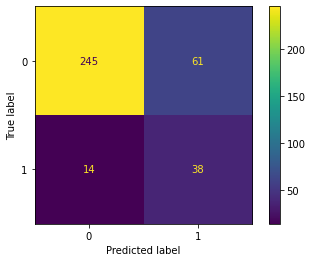

Recall (Sensivity): 0.73
Specificity: 0.8
Precision: 0.38
Balanced Accuracy: 0.76
F1 Score: 0.5
Profit: 81
Wall time: 3.1 s


In [26]:
%%time

scores, lr_best_est =classGridSearchCV('orig', lr, parameters, Xtrain, y_train, Xval, y_val, 'f1', scores)

In [27]:
pd.get_option('display.max_colwidth') # don't forget to reset this back to 50
pd.set_option('display.max_colwidth', 500)

In [28]:
scores

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=0.5, class_weight='balanced', random_state=0)",0.79,0.79,0.0,0.73,0.8,0.38,0.76,0.5,81


### Support Vector Machines Classifier (SVC)

In [29]:
parameters = {
     'C': [1, 10, 25, 50, 100, 200, 300],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale'] ,
    'kernel': ['linear', 'rbf']
}
parameters

{'C': [1, 10, 25, 50, 100, 200, 300],
 'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
 'kernel': ['linear', 'rbf']}

In [30]:
svc = SVC(class_weight='balanced', random_state=RANDOM_STATE)

BEST PARAMS: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}



The model's accuracy on training is : 0.85
The model's accuracy on validation is : 0.8

The Confusion Matrix is given below:


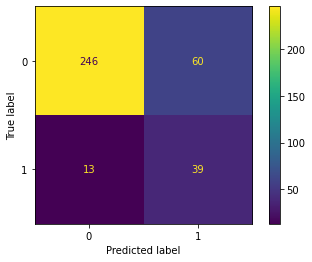

Recall (Sensivity): 0.75
Specificity: 0.8
Precision: 0.39
Balanced Accuracy: 0.78
F1 Score: 0.51
Profit: 106
Wall time: 2min 5s


In [31]:
%%time

scores, svc_best_est =classGridSearchCV('orig', svc, parameters, Xtrain, y_train, Xval, y_val, 'f1', scores)

In [32]:
scores

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=0.5, class_weight='balanced', random_state=0)",0.79,0.79,0.00,0.73,0.8,0.38,0.76,0.50,81
1,"SVC(C=100, class_weight='balanced', gamma=0.01, random_state=0)",0.85,0.80,0.05,0.75,0.8,0.39,0.78,0.51,106


### KNN Classifier

In [33]:
parameters = {
    'n_neighbors': [1, 3, 5, 10],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [2, 5, 15, 30, 50, 100, 200]
}

In [34]:
knc = KNeighborsClassifier()

BEST PARAMS: {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 5, 'weights': 'uniform'}



The model's accuracy on training is : 0.88
The model's accuracy on validation is : 0.87

The Confusion Matrix is given below:


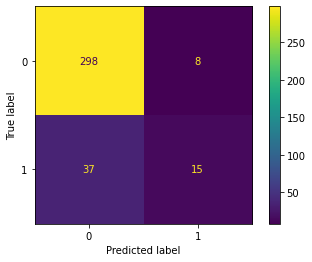

Recall (Sensivity): 0.29
Specificity: 0.97
Precision: 0.65
Balanced Accuracy: 0.63
F1 Score: 0.4
Profit: -266
Wall time: 9.26 s


In [35]:
%%time

scores, knc_best_est =classGridSearchCV('orig', knc, parameters, Xtrain, y_train, Xval, y_val, 'f1', scores)

In [36]:
scores

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=0.5, class_weight='balanced', random_state=0)",0.79,0.79,0.00,0.73,0.80,0.38,0.76,0.50,81
1,"SVC(C=100, class_weight='balanced', gamma=0.01, random_state=0)",0.85,0.80,0.05,0.75,0.80,0.39,0.78,0.51,106
2,"KNeighborsClassifier(algorithm='ball_tree', leaf_size=5)",0.88,0.87,0.01,0.29,0.97,0.65,0.63,0.40,-266


### Decision Tree Classifier

In [37]:
parameters = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split' : [2, 5, 10, 30, 50, 70],
    'min_samples_leaf' : [2, 5, 10, 30, 50],
    'max_features' : [2,5,18]
}

In [38]:
dt = DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE)

BEST PARAMS: {'max_depth': 10, 'max_features': 18, 'min_samples_leaf': 10, 'min_samples_split': 70}



The model's accuracy on training is : 0.8
The model's accuracy on validation is : 0.79

The Confusion Matrix is given below:


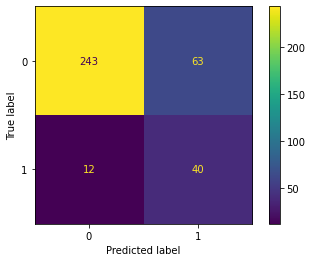

Recall (Sensivity): 0.77
Specificity: 0.79
Precision: 0.39
Balanced Accuracy: 0.78
F1 Score: 0.52
Profit: 119
Wall time: 7.94 s


In [39]:
%%time

scores, dt_best_est =classGridSearchCV('orig', dt, parameters, Xtrain, y_train, Xval, y_val, 'f1', scores)

In [40]:
scores

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=0.5, class_weight='balanced', random_state=0)",0.79,0.79,0.00,0.73,0.80,0.38,0.76,0.50,81
1,"SVC(C=100, class_weight='balanced', gamma=0.01, random_state=0)",0.85,0.80,0.05,0.75,0.80,0.39,0.78,0.51,106
2,"KNeighborsClassifier(algorithm='ball_tree', leaf_size=5)",0.88,0.87,0.01,0.29,0.97,0.65,0.63,0.40,-266
3,"DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_features=18,\n min_samples_leaf=10, min_samples_split=70,\n random_state=0)",0.80,0.79,0.01,0.77,0.79,0.39,0.78,0.52,119


### Random Forest Classifier

In [41]:
parameters = {
    'n_estimators' : [50, 150, 200],
    'max_depth': [1, 10, 100],
    'min_samples_split' : [2, 100, 300],
    'bootstrap': [True, False],
    'max_features': [2,5,18],
}

In [42]:
rf = RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE)

BEST PARAMS: {'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'min_samples_split': 100, 'n_estimators': 50}



The model's accuracy on training is : 0.81
The model's accuracy on validation is : 0.82

The Confusion Matrix is given below:


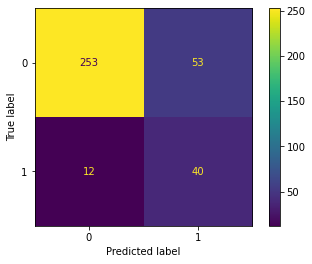

Recall (Sensivity): 0.77
Specificity: 0.83
Precision: 0.43
Balanced Accuracy: 0.8
F1 Score: 0.55
Profit: 149
Wall time: 2min 19s


In [43]:
%%time

scores, rf_best_est =classGridSearchCV('orig', rf, parameters, Xtrain, y_train, Xval, y_val, 'f1', scores)

In [44]:
scores

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=0.5, class_weight='balanced', random_state=0)",0.79,0.79,0.00,0.73,0.80,0.38,0.76,0.50,81
1,"SVC(C=100, class_weight='balanced', gamma=0.01, random_state=0)",0.85,0.80,0.05,0.75,0.80,0.39,0.78,0.51,106
2,"KNeighborsClassifier(algorithm='ball_tree', leaf_size=5)",0.88,0.87,0.01,0.29,0.97,0.65,0.63,0.40,-266
3,"DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_features=18,\n min_samples_leaf=10, min_samples_split=70,\n random_state=0)",0.80,0.79,0.01,0.77,0.79,0.39,0.78,0.52,119
4,"RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,\n min_samples_split=100, n_estimators=50, random_state=0)",0.81,0.82,-0.01,0.77,0.83,0.43,0.80,0.55,149


### Adaboost Classifier

In [45]:
parameters = {
    'n_estimators' : [50, 250, 400],
    'learning_rate': [0.5, 1.5, 2.0]
}

In [46]:
ab = AdaBoostClassifier(random_state=RANDOM_STATE)

BEST PARAMS: {'learning_rate': 0.5, 'n_estimators': 50}



The model's accuracy on training is : 0.88
The model's accuracy on validation is : 0.91

The Confusion Matrix is given below:


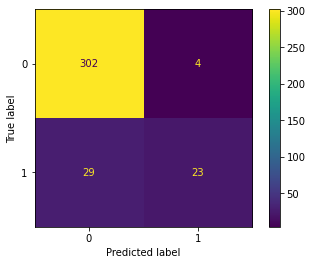

Recall (Sensivity): 0.44
Specificity: 0.99
Precision: 0.85
Balanced Accuracy: 0.72
F1 Score: 0.58
Profit: -78
Wall time: 14.3 s


In [47]:
%%time

scores, ab_best_est =classGridSearchCV('orig', ab, parameters, Xtrain, y_train, Xval, y_val, 'f1', scores)

In [48]:
scores

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=0.5, class_weight='balanced', random_state=0)",0.79,0.79,0.00,0.73,0.80,0.38,0.76,0.50,81
1,"SVC(C=100, class_weight='balanced', gamma=0.01, random_state=0)",0.85,0.80,0.05,0.75,0.80,0.39,0.78,0.51,106
2,"KNeighborsClassifier(algorithm='ball_tree', leaf_size=5)",0.88,0.87,0.01,0.29,0.97,0.65,0.63,0.40,-266
3,"DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_features=18,\n min_samples_leaf=10, min_samples_split=70,\n random_state=0)",0.80,0.79,0.01,0.77,0.79,0.39,0.78,0.52,119
4,"RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,\n min_samples_split=100, n_estimators=50, random_state=0)",0.81,0.82,-0.01,0.77,0.83,0.43,0.80,0.55,149
5,"AdaBoostClassifier(learning_rate=0.5, random_state=0)",0.88,0.91,-0.03,0.44,0.99,0.85,0.72,0.58,-78


### Gradient Boosting Classifier

In [49]:
parameters = dict(
    learning_rate = [0.1, 0.5, 1.5],
    n_estimators = [30, 200, 600],
    max_depth = [2, 5, 6],
    min_samples_split = [2, 10, 100],
    subsample = [0.5, 1]
    )

In [50]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 100, 'n_estimators': 200, 'subsample': 0.5}



The model's accuracy on training is : 0.97
The model's accuracy on validation is : 0.9

The Confusion Matrix is given below:


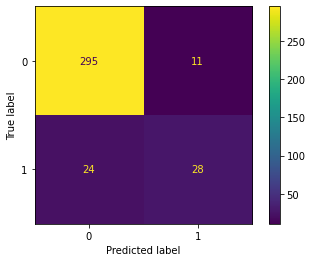

Recall (Sensivity): 0.54
Specificity: 0.96
Precision: 0.72
Balanced Accuracy: 0.75
F1 Score: 0.62
Profit: 11
Wall time: 5min 11s


In [51]:
%%time

scores, gb_best_est =classGridSearchCV('orig', gb, parameters, Xtrain, y_train, Xval, y_val, 'f1', scores)

In [52]:
scores

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=0.5, class_weight='balanced', random_state=0)",0.79,0.79,0.00,0.73,0.80,0.38,0.76,0.50,81
1,"SVC(C=100, class_weight='balanced', gamma=0.01, random_state=0)",0.85,0.80,0.05,0.75,0.80,0.39,0.78,0.51,106
2,"KNeighborsClassifier(algorithm='ball_tree', leaf_size=5)",0.88,0.87,0.01,0.29,0.97,0.65,0.63,0.40,-266
3,"DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_features=18,\n min_samples_leaf=10, min_samples_split=70,\n random_state=0)",0.80,0.79,0.01,0.77,0.79,0.39,0.78,0.52,119
4,"RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,\n min_samples_split=100, n_estimators=50, random_state=0)",0.81,0.82,-0.01,0.77,0.83,0.43,0.80,0.55,149
5,"AdaBoostClassifier(learning_rate=0.5, random_state=0)",0.88,0.91,-0.03,0.44,0.99,0.85,0.72,0.58,-78
6,"GradientBoostingClassifier(max_depth=5, min_samples_split=100, n_estimators=200,\n random_state=0, subsample=0.5)",0.97,0.90,0.07,0.54,0.96,0.72,0.75,0.62,11


The Random Forest Classifier performed the best on the original standardized dataset, with a profit score of 149. The Decision Tree Classifier had the next highest profit, at 119.

## Create and Build Models Using Balanced Dataset

In [53]:
y_train.value_counts()

0    1206
1     224
Name: Response, dtype: int64

The **Synthetic Minority OverSampling Technique** (SMOTE) package was used to create a more balanced dataset by oversampling the majority class using SMOTE and randomly undersampling the minority class with the goal of addressing the class imbalance problem and improving model performance.

In [54]:
sampling_strategy_u = {0 : 500} 
sampling_strategy_o = {1: 800}

# transform the data set

overSample = SMOTE(sampling_strategy=sampling_strategy_o)
underSample = RandomUnderSampler(sampling_strategy=sampling_strategy_u)
# create the steps
steps = [('o', overSample), ('u', underSample)]

# create a pipeline object using the steps as your parameter
pipeline=Pipeline(steps=steps)
XtrainT, y_trainT = pipeline.fit_resample(Xtrain, y_train)

Now that we have a balanced data set, let's explore how we can **tune** the different classification algorithms.

### Logistic Regression

In [55]:
# Use GridSearchCV to find the **hyper parameters** for **Logistic regression**.

parameters = {
    'C': [0.1, 0.5, 1, 10, 20, 30, 50]
    #'max_iter' : [10, 100, 200, 300, 500]
} 
parameters

{'C': [0.1, 0.5, 1, 10, 20, 30, 50]}

In [56]:
lr=LogisticRegression(max_iter=10000, random_state=RANDOM_STATE, solver='lbfgs')

BEST PARAMS: {'C': 10}



The model's accuracy on training is : 0.81
The model's accuracy on validation is : 0.66

The Confusion Matrix is given below:


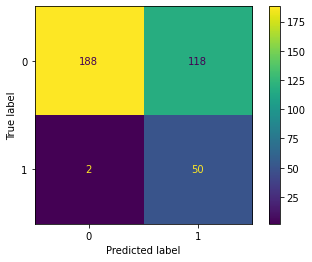

Recall (Sensivity): 0.96
Specificity: 0.61
Precision: 0.3
Balanced Accuracy: 0.78
F1 Score: 0.46
Profit: 174
Wall time: 656 ms


In [57]:
%%time
scores_balanced_ds, lr_bal_best_est =classGridSearchCV('bal', lr, parameters, XtrainT, y_trainT, Xval, y_val, 'f1', scores_balanced_ds)

In [58]:
scores_balanced_ds

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=10, max_iter=10000, random_state=0)",0.81,0.66,0.15,0.96,0.61,0.3,0.78,0.46,174


### Support Vector Machines Classifier

In [59]:
parameters = {
    'C': [.01, .1, 1, 10, 25, 50, 100, 200, 300],
    'gamma': [0.1, 1, 2],
    'kernel': ['linear', 'rbf']
}
parameters

{'C': [0.01, 0.1, 1, 10, 25, 50, 100, 200, 300],
 'gamma': [0.1, 1, 2],
 'kernel': ['linear', 'rbf']}

In [60]:
svc = SVC(random_state=RANDOM_STATE)

BEST PARAMS: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}



The model's accuracy on training is : 0.99
The model's accuracy on validation is : 0.8

The Confusion Matrix is given below:


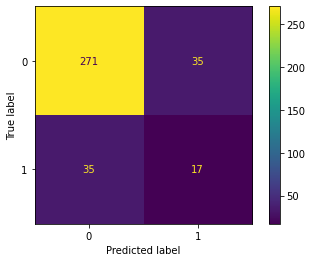

Recall (Sensivity): 0.33
Specificity: 0.89
Precision: 0.33
Balanced Accuracy: 0.61
F1 Score: 0.33
Profit: -303
Wall time: 1min 18s


In [61]:
%%time
scores_balanced_ds, svc_bal_best_est =classGridSearchCV('bal', svc, parameters, XtrainT, y_trainT, Xval, y_val, 'f1', scores_balanced_ds)

In [62]:
scores_balanced_ds

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=10, max_iter=10000, random_state=0)",0.81,0.66,0.15,0.96,0.61,0.30,0.78,0.46,174
1,"SVC(C=1, gamma=1, random_state=0)",0.99,0.80,0.19,0.33,0.89,0.33,0.61,0.33,-303


### KNN Classifier

In [63]:
parameters = {
    'n_neighbors': [1, 3, 5, 10],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [2, 5, 15, 30, 50, 100, 200]
}

In [64]:
knc = KNeighborsClassifier()

BEST PARAMS: {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 1, 'weights': 'uniform'}



The model's accuracy on training is : 1.0
The model's accuracy on validation is : 0.72

The Confusion Matrix is given below:


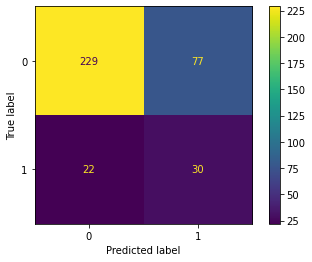

Recall (Sensivity): 0.58
Specificity: 0.75
Precision: 0.28
Balanced Accuracy: 0.66
F1 Score: 0.38
Profit: -143
Wall time: 7.82 s


In [65]:
%%time
scores_balanced_ds, knc_bal_best_est =classGridSearchCV('bal', knc, parameters, XtrainT, y_trainT, Xval, y_val, 'f1', scores_balanced_ds)

In [66]:
scores_balanced_ds

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=10, max_iter=10000, random_state=0)",0.81,0.66,0.15,0.96,0.61,0.30,0.78,0.46,174
1,"SVC(C=1, gamma=1, random_state=0)",0.99,0.80,0.19,0.33,0.89,0.33,0.61,0.33,-303
2,"KNeighborsClassifier(leaf_size=2, n_neighbors=1)",1.00,0.72,0.28,0.58,0.75,0.28,0.66,0.38,-143


### Decision Tree Classifier

In [67]:
parameters = {
    'max_depth': [5, 10, 15],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [2, 5, 10, 100],
    'max_features': [1, 5, 18]
}

In [68]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

BEST PARAMS: {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}



The model's accuracy on training is : 0.9
The model's accuracy on validation is : 0.74

The Confusion Matrix is given below:


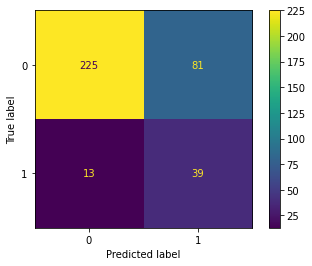

Recall (Sensivity): 0.75
Specificity: 0.74
Precision: 0.32
Balanced Accuracy: 0.74
F1 Score: 0.45
Profit: 43
Wall time: 2.38 s


In [69]:
%%time
scores_balanced_ds, dt_bal_best_est =classGridSearchCV('bal', dt, parameters, XtrainT, y_trainT, Xval, y_val, 'f1', scores_balanced_ds)

In [70]:
scores_balanced_ds

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=10, max_iter=10000, random_state=0)",0.81,0.66,0.15,0.96,0.61,0.30,0.78,0.46,174
1,"SVC(C=1, gamma=1, random_state=0)",0.99,0.80,0.19,0.33,0.89,0.33,0.61,0.33,-303
2,"KNeighborsClassifier(leaf_size=2, n_neighbors=1)",1.00,0.72,0.28,0.58,0.75,0.28,0.66,0.38,-143
3,"DecisionTreeClassifier(max_depth=10, max_features=5, min_samples_leaf=5,\n random_state=0)",0.90,0.74,0.16,0.75,0.74,0.32,0.74,0.45,43


### Random Forest Classifier

In [71]:
parameters = {
    'n_estimators' : [50, 100, 150],
    'max_depth': [5,10,20],
    'min_samples_split' : [2, 10, 50],
    'max_features': [2, 5, 18],
    'bootstrap': [True, False]
}

In [72]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

BEST PARAMS: {'bootstrap': False, 'max_depth': 20, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 150}



The model's accuracy on training is : 1.0
The model's accuracy on validation is : 0.82

The Confusion Matrix is given below:


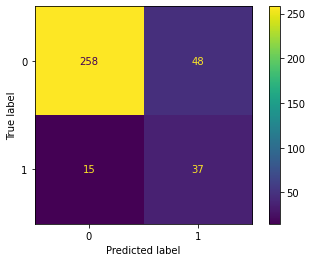

Recall (Sensivity): 0.71
Specificity: 0.84
Precision: 0.44
Balanced Accuracy: 0.77
F1 Score: 0.54
Profit: 98
Wall time: 2min 19s


In [73]:
%%time
scores_balanced_ds, rf_bal_best_est =classGridSearchCV('bal', rfc, parameters, XtrainT, y_trainT, Xval, y_val, 'f1', scores_balanced_ds)

In [74]:
scores_balanced_ds

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=10, max_iter=10000, random_state=0)",0.81,0.66,0.15,0.96,0.61,0.30,0.78,0.46,174
1,"SVC(C=1, gamma=1, random_state=0)",0.99,0.80,0.19,0.33,0.89,0.33,0.61,0.33,-303
2,"KNeighborsClassifier(leaf_size=2, n_neighbors=1)",1.00,0.72,0.28,0.58,0.75,0.28,0.66,0.38,-143
3,"DecisionTreeClassifier(max_depth=10, max_features=5, min_samples_leaf=5,\n random_state=0)",0.90,0.74,0.16,0.75,0.74,0.32,0.74,0.45,43
4,"RandomForestClassifier(bootstrap=False, max_depth=20, max_features=2,\n n_estimators=150, random_state=0)",1.00,0.82,0.18,0.71,0.84,0.44,0.77,0.54,98


### Adaboost Classifier

In [75]:
parameters = {
    'n_estimators' : [200, 400, 600],
    'learning_rate': [0.3, 0.5, 1.0]
}

In [76]:
ab = AdaBoostClassifier(random_state=RANDOM_STATE)

BEST PARAMS: {'learning_rate': 1.0, 'n_estimators': 200}



The model's accuracy on training is : 0.92
The model's accuracy on validation is : 0.8

The Confusion Matrix is given below:


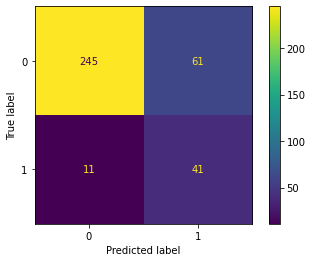

Recall (Sensivity): 0.79
Specificity: 0.8
Precision: 0.4
Balanced Accuracy: 0.8
F1 Score: 0.53
Profit: 147
Wall time: 25.1 s


In [77]:
%%time
scores_balanced_ds, ab_bal_best_est =classGridSearchCV('bal', ab, parameters, XtrainT, y_trainT, Xval, y_val, 'f1', scores_balanced_ds)

In [78]:
scores_balanced_ds

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=10, max_iter=10000, random_state=0)",0.81,0.66,0.15,0.96,0.61,0.30,0.78,0.46,174
1,"SVC(C=1, gamma=1, random_state=0)",0.99,0.80,0.19,0.33,0.89,0.33,0.61,0.33,-303
2,"KNeighborsClassifier(leaf_size=2, n_neighbors=1)",1.00,0.72,0.28,0.58,0.75,0.28,0.66,0.38,-143
3,"DecisionTreeClassifier(max_depth=10, max_features=5, min_samples_leaf=5,\n random_state=0)",0.90,0.74,0.16,0.75,0.74,0.32,0.74,0.45,43
4,"RandomForestClassifier(bootstrap=False, max_depth=20, max_features=2,\n n_estimators=150, random_state=0)",1.00,0.82,0.18,0.71,0.84,0.44,0.77,0.54,98
5,"AdaBoostClassifier(n_estimators=200, random_state=0)",0.92,0.80,0.12,0.79,0.80,0.40,0.80,0.53,147


### Gradient Boosting Classifier

In [79]:
parameters = dict(
    learning_rate = [0.1,  0.5, 1.5],
    n_estimators = [30,  200, 600],
    max_depth = [2, 3, 6],
    min_samples_split = [2,  10, 100],
    subsample = [0.5, 1]
    )

In [80]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

BEST PARAMS: {'learning_rate': 0.5, 'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 1}



The model's accuracy on training is : 1.0
The model's accuracy on validation is : 0.82

The Confusion Matrix is given below:


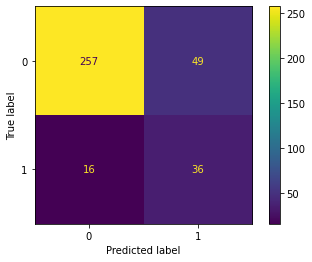

Recall (Sensivity): 0.69
Specificity: 0.84
Precision: 0.42
Balanced Accuracy: 0.76
F1 Score: 0.52
Profit: 73
Wall time: 4min 37s


In [81]:
%%time
scores_balanced_ds, gb_bal_best_est =classGridSearchCV('bal', gb, parameters, XtrainT, y_trainT, Xval, y_val, 'f1', scores_balanced_ds)

In [82]:
scores_balanced_ds

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=10, max_iter=10000, random_state=0)",0.81,0.66,0.15,0.96,0.61,0.30,0.78,0.46,174
1,"SVC(C=1, gamma=1, random_state=0)",0.99,0.80,0.19,0.33,0.89,0.33,0.61,0.33,-303
2,"KNeighborsClassifier(leaf_size=2, n_neighbors=1)",1.00,0.72,0.28,0.58,0.75,0.28,0.66,0.38,-143
3,"DecisionTreeClassifier(max_depth=10, max_features=5, min_samples_leaf=5,\n random_state=0)",0.90,0.74,0.16,0.75,0.74,0.32,0.74,0.45,43
4,"RandomForestClassifier(bootstrap=False, max_depth=20, max_features=2,\n n_estimators=150, random_state=0)",1.00,0.82,0.18,0.71,0.84,0.44,0.77,0.54,98
5,"AdaBoostClassifier(n_estimators=200, random_state=0)",0.92,0.80,0.12,0.79,0.80,0.40,0.80,0.53,147
6,"GradientBoostingClassifier(learning_rate=0.5, max_depth=6, min_samples_split=10,\n n_estimators=200, random_state=0, subsample=1)",1.00,0.82,0.18,0.69,0.84,0.42,0.76,0.52,73


In [83]:
scores

,model,train acc.,val acc.,acc. diff.,recall,specificity,precision,bal acc.,F1,profit
0,"LogisticRegression(C=0.5, class_weight='balanced', random_state=0)",0.79,0.79,0.00,0.73,0.80,0.38,0.76,0.50,81
1,"SVC(C=100, class_weight='balanced', gamma=0.01, random_state=0)",0.85,0.80,0.05,0.75,0.80,0.39,0.78,0.51,106
2,"KNeighborsClassifier(algorithm='ball_tree', leaf_size=5)",0.88,0.87,0.01,0.29,0.97,0.65,0.63,0.40,-266
3,"DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_features=18,\n min_samples_leaf=10, min_samples_split=70,\n random_state=0)",0.80,0.79,0.01,0.77,0.79,0.39,0.78,0.52,119
4,"RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,\n min_samples_split=100, n_estimators=50, random_state=0)",0.81,0.82,-0.01,0.77,0.83,0.43,0.80,0.55,149
5,"AdaBoostClassifier(learning_rate=0.5, random_state=0)",0.88,0.91,-0.03,0.44,0.99,0.85,0.72,0.58,-78
6,"GradientBoostingClassifier(max_depth=5, min_samples_split=100, n_estimators=200,\n random_state=0, subsample=0.5)",0.97,0.90,0.07,0.54,0.96,0.72,0.75,0.62,11


The tuned Logistic Regression produced the highest profit of 174 using the SMOTE oversampled and random undersampled dataset, significantly improving performance over the Logistic Regression Model that was tuned using the original standardized dataset. The AdaBoost Classifier produced the next highest profit of 147 using the balanced dataset, which was also a significant improvement compared to the model tuned using the original standardized dataset. The Random Forest Classifier produced the third highest profit score of 98, which was a decrease compared to its score of 149 using the original standardized dataset.

# Evaluation of two best models on Test Data

## Predict the accuracy on the testing data set using the best models:

In [84]:
# Initilalize a list of best two classifiers tested on the testing data set.
best_two_classifiers_on_Test=[]



*   First, using logistic Regression model derived using the under-sampled, over-sampled data set through the use of the SMOTE package:



In [85]:
# Predict the accuracy on the testing data set
y_pred_test = lr_bal_best_est.predict(Xtest)


The Confusion Matrix is given below:


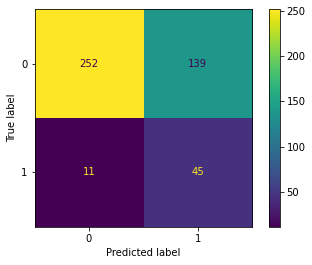

Recall (Sensivity): 0.8
Specificity: 0.64
Precision: 0.24
Balanced Accuracy: 0.72
F1 Score: 0.37
Profit: -43


In [86]:
# A helper function that returns the metrics on the testing data set, prints a confusion matrix and also returns back a list of all the metrics. 
best_two_classifiers_on_Test.append(deriveMetricsOnTest(lr_bal_best_est, y_pred_test))



*   Second, using a Random Forest Classifier optimized with GridSearchCV:



In [87]:
# predict the accuracy on the testing data set
y_pred_test = rf_best_est.predict(Xtest)


The Confusion Matrix is given below:


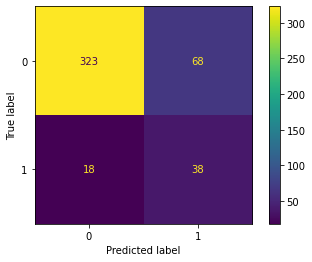

Recall (Sensivity): 0.68
Specificity: 0.83
Precision: 0.36
Balanced Accuracy: 0.76
F1 Score: 0.47
Profit: 16


In [88]:
# A helper function that returns the metrics on the testing data set, prints a confusion matrix and also returns back a list of all the metrics. 
best_two_classifiers_on_Test.append(deriveMetricsOnTest(rf_best_est, y_pred_test))

In [90]:
# Derive a data frame
df_classifiers_test = pd.DataFrame(data=best_two_classifiers_on_Test, columns=['Model', 'AccuracyOnTest', 'RecallOnTest', 'SpecificityOnTest', 'PrecisionOnTest', 'BalancedAccuracyOnTest', 'F1ScoreOnTest','Profit'])
df_classifiers_test # displaying the contents of the data frame


,Model,AccuracyOnTest,RecallOnTest,SpecificityOnTest,PrecisionOnTest,BalancedAccuracyOnTest,F1ScoreOnTest,Profit
0,"LogisticRegression(C=10, max_iter=10000, random_state=0)",0.66,0.80,0.64,0.24,0.72,0.37,-43
1,"RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,\n min_samples_split=100, n_estimators=50, random_state=0)",0.81,0.68,0.83,0.36,0.76,0.47,16


The Random Forest Classifier produced the higher profit score of 16 on the test data, compared to a profit score of -43 on the Logistic Regression Classifier. The performance of both classifiers on the test set was much lower compared to their performance on the training and validation data.

# Examination of Variable Importance

Examined variable importance using the random forest best estimator feature importance attribute. The most important features identified are number of previously accepted campaigns, recency, and amount spent.

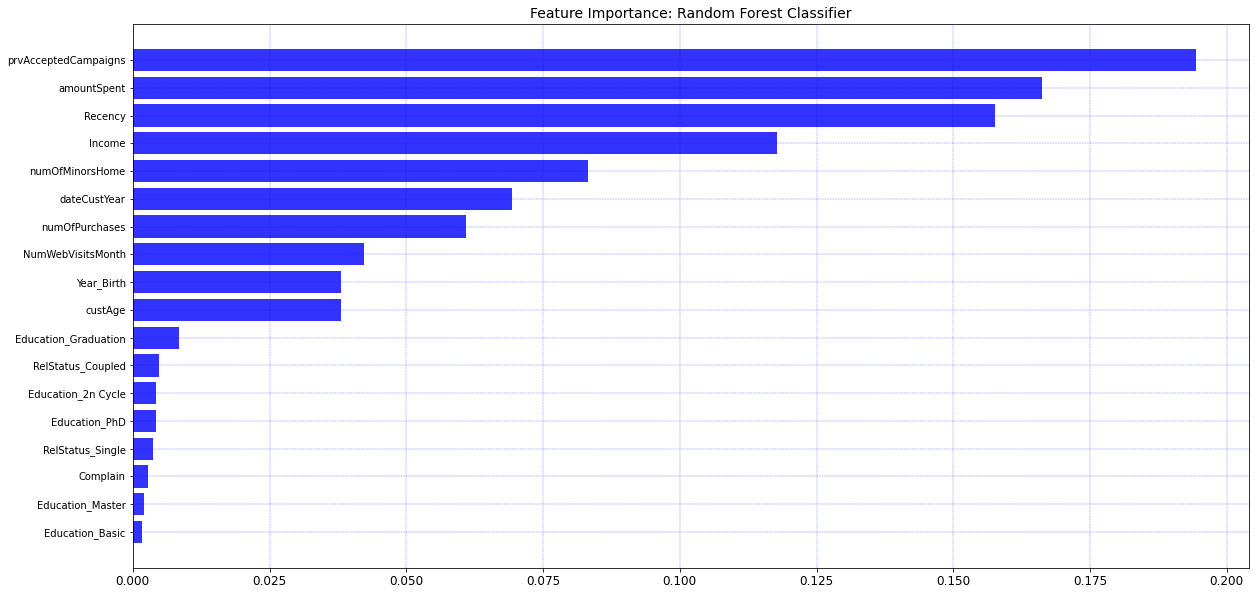

In [91]:
model_type = 'rf' 
model_dict = {'rf':rf_best_est.feature_importances_}
importances = model_dict[model_type]
indices = list(np.argsort(importances)) 
feature_names=Xtrain.columns
names = [ feature_names[i] for i in indices]

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=[20,10])
ax.barh(names, importances[indices], color = 'blue', align ='center',alpha=0.8)

xticklabel_rotation = 0
plt.xticks(rotation=xticklabel_rotation,fontsize=12)

plt.yticks(fontsize=10)
ax.grid(color='b', ls = '-.', lw = 0.25)

# Title
ax.set_title("Feature Importance: Random Forest Classifier",fontsize=14)

# Show plot
plt.show()

## Conclusion

The Random Forest Classifier performed better on the test data compared to the Logistic Regression, producing a profit of 16 dollars, compared to -43 dollars for the Logistic Regression classifier. Although the Logistic Regression classifier had a higher recall score, the Random Forest Classifier also had a higher test accuracy, specificity, precision, balanced accuracy and F1 score.  Futhermore, analysis of variable importance indicates companies may want to target customers who previously accepted campaigns, spend more, and were more recently contacted.